## Домашнее задание 1

Это домашнее задание по трём первым семинарам содержит всего 3 задачи, поэтому, пожалуйста, постарайтесь выписать свои рассуждения максимально подробно. Задачи в этом задании модельные и требуют для решения трёх вещей: умения строить модели, теоретически рассуждать в терминах математической статистики и проводить статистическое моделирование, используя питон с библиотеками.

Теорию можно оформить прямо в ноутбуке, для этого нужно сменить тип ячейки на markdown (как здесь) и писать на языке разметки LaTeX (как $\textbf{здесь}$). Если вам это не удобно можете сфотографировать письменное решение и прислать вместе с этим ноутбуком.

Инструкция по установке всего, что нужно:
- установить python3 и pip (зависит от вашей операционной системы)
- ввести в терминале: pip install notebook, numpy, matplotlib, scipy

In [ ]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Карта для беспилотника
Беспилотные автомобили, имеющие на своём борту сенсор технологии LiDAR, перемещаясь по городу, могут собрать целую 3-д карту местности. Дело в том, что такие датчики посылают и принимают световые лучи во всех направлениях, а на выходе беспилотник получает облако точек — отражений от дорог, домов, деревьев и так далее. Собрав все точки в одной системе координат и удалив других участников движения, разработчики получают так называемую HD-карту местности. 

![pointcloud.png](attachment:pointcloud.png)

Вам предлагается по сгенерированным данным, похожим на лидарные, построить из такой 3D-карты точек 2D-карту высот. Для простоты можно считать, что на вход нам приходят точки карты в виде 3 массивов - их координаты x, y и z соответственно, причём плоскость $Oxy$ совпадает с плоскостью дороги, а координата $z$ каждой точки - это её высота над землёй.

- Так в чём проблема? Можно просто взять высоты точек и расположить их на плоскости - это и будет искомой картой высот.

Главная проблема состоит в том, что лидарные данные очень шумные. Датчик ошибается, трясётся при поездке, а также иногда лучи отражаются от пыли над дорогой или капель дождя. Однако, посоветовавшись с инженерами вы узнали, что $\textit{точек шума над дорогой всегда примерно столько же, сколько под дорогой}$.

Для построения гладкой карты высот плоскость дороги разбивают на сетку так, что в каждой ячейке оказываются несколько точек. Далее в каждом таком "пикселе" надо каким-то образом оценить возвышение плоскости дороги используя точки, попавшие в него, в идеале исключая шум. Можно считать что в пределах пикселя дорога плоская (наклона нет).

Вам и нужно предложить такую оценку. Конкретно: пусть в ячейку попало $n$ точек, из них некоторые - это реальные точки плоскости дороги, некоторые - это шум. 
- Укажите $\textit{а какой именно параметр}$ распределения высот точек нужно оценивать для получения карты высот
- Имея выборку высот $Z_1, \dots, Z_n$ предложите оценку высоты дорожного полотна $\hat{h}(\textbf Z^n)$ так, чтобы шум минимально влиял на итоговый результат. 
- Объясните, почему предложенная вами оценка хороша в данном случае, предположите её свойства

- Дополнительный пункт. Проверьте статистическим моделированием выполнение предположенных свойств оценки. Сгенерируйте выборку размера N (например, 10000) из распределения на ваш выбор. Представьте, что вся сгенерированная выборка попала в одну клетку.  

Напомню, что состоятельность или асимптотическую нормальность можно проверить, вычислив значение оценки для всех размеров выборки от 1 до N. Несмещённость можно проверить бутстрапным методом (M выборок).

##### проверим предположение экспериментально

В качестве экспериментальных данных нам предлагается сцена, на которой видны ступеньки. Модель сцены закодирована в файле `raw_scene.bin`.

In [ ]:
with open('raw_scene.bin', 'rb') as f:
    x = np.load(f)
    y = np.load(f)
    z = np.load(f)

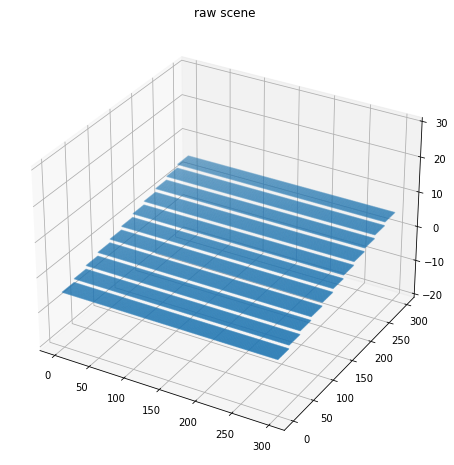

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(projection='3d')
ax1.set_zlim((-20, 30))
ax1.set_title("raw scene")
ax1.scatter(x, y, z, s=0.05)

В соседнем файле `point_cloud.bin` находятся смоделированные лидарные данные съёмки такой сцены.

In [ ]:
with open('point_cloud.bin', 'rb') as f:
    x_l = np.load(f)
    y_l = np.load(f)
    z_l = np.load(f)

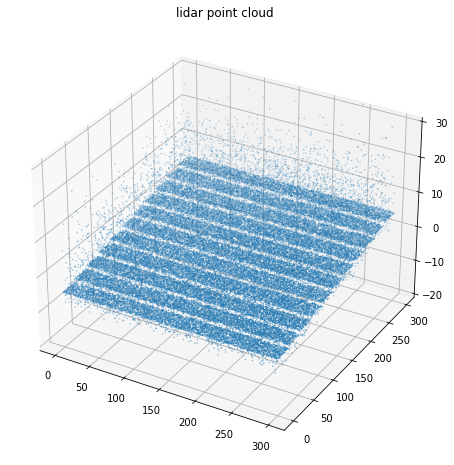

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(projection='3d')
ax1.set_zlim((-20, 30))
ax1.set_title("lidar point cloud")
ax1.scatter(x_l, y_l, z_l, s=0.1)

Данная функция разбивает плоскость $Oxy$ на сетку 100х100 и в соответствующую ячейку помещает список z-координат попавших в неё точек.

In [ ]:
def make_grid(x, y, z):
    M = 100
    grid = [[[] for i in range(M)] for i in range(M)]
    
    max_x = np.max(x)
    max_y = np.max(y)
    min_x = np.min(x)
    min_y = np.min(y)
    
    step_x = (max_x - min_x) / M 
    step_y = (max_y - min_y) / M 

    for i in range(len(x)):
        index_x = max(0, int((x[i] - min_x) / step_x) - 1)
        index_y = max(0, int((y[i] - min_y) / step_y) - 1)
        
        grid[index_x][index_y].append(z[i])
        
    return grid

In [ ]:
grid = make_grid(x_l, y_l, z_l)

Осталось в каждой ячейке сетки применить оценку. В функции ниже реализуйте предложенную вами оценку высоты $\hat{h}(\textbf Z^n)$.

In [ ]:
def estimator(sample):
    sample = np.array(sample)
    return # YOUR CODE HERE

In [ ]:
def draw_heights_map(grid, estimator):
    M = 100
    image = np.zeros((100, 100))
    for i in range(M):
        for j in range(M):
            image[i,j] = estimator(grid[i][j])
            
    fig, ax = plt.subplots(1, figsize=(10,10))
    plt.title('Heights map')
    im = plt.imshow(image)
    ax.figure.colorbar(im, ax=ax)

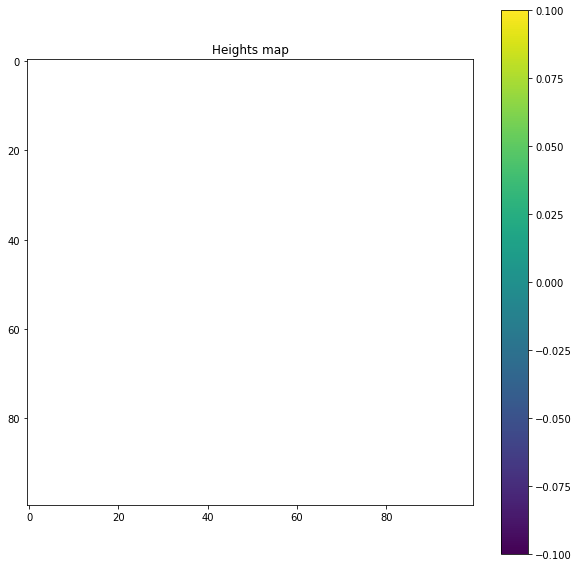

In [ ]:
draw_heights_map(grid, estimator)

Опишите, подтвердил ли гипотезу эксперимент.

### 2. Московское метро

В московском метро решили установить систему распознавания лиц. Но разработчики столкнулись с проблемой — они не знают, какая нужна вместимость сервера по памяти, чтобы хранить снимки одной камеры за целый день.
Они ограничили объём одного фото 1Мб. Пройдя ад бюрократии и собрав данные, они узнали, что через один фиксированный турникет в разные дни года проходило:

In [ ]:
with open("people.bin", "rb") as f:
    people = np.load(f)
    
print(people)

[10677 11493 11158 10505 11138 11575 10963 10948 11265 10845 10925 11081
 10778 10018 11827 10808 10655  9930 10190 11172 11090 11072 11238 10736
 11698 11498 11516 10572 11213 10950 11548 11640 10474 11215 11054 11498
 11433 10673 10360 11798 10892 10838 11656 10604 10244 10559 10715 10957
 10556 11010 10909 10173 10626 11867  9898 11261 10834 11500 10229 10885
 10260 10378 11306 10781 10717 10958 11497 11229 10965 10836 11053 11698
 11032 10389 11097 10951 11675 10983 11409 11279 11710 11700 11392 10945
 11401 11289 10877 11282 11008 10810 11147  9891 10844 10797 11183 11712
 10892 10786 11492 10169 11566 11002 11222 10729 11944 11904 11120  9884
 10126 10395 11148 10845 11869 11279 11248 10665 11907 11344 10622 11142
 11167 11602 10898 11199 10819 10813  9946 10469 11271 10250 11528 10947
 10690 11521 11224 10591 10607 10792 11319 11011 10948 11740 10959 10892
 10878 10562 11441 10800  9842 11463 11101 11053 11194 11158 11512 11092
 11584 11257 11387 10454 11574 11131 10957 11111 11

Ваш коллега увидел данные и сказал, что 12000Мбайт хватит. Вы хотите уберечь его от ошибки и доказать ему, что он неправ.
 1. Графически проиллюстрируйте распределение выборки. Выдвиньте гипотезу — из какого семейства распределений пришли данные? Ничего страшного, если по графику не будет однозначно понятно распределение - обычно так и бывает.
 2. В полученной модели оцените параметры распределения. Используя полученные оценки оцените вероятность того, что в случайный день памяти, предложенной коллегой,  не хватит.
 3. Постройте интервал доверия для параметров распределения с высоким уровнем (например 0.99). В «худшем» случае значений параметров перебором найдите такое значение памяти, что вероятность перегрузки сервера не будет превышать 0.1%.
 4. Хороший ли это способ подбора значения памяти? Может быть вы можете предложить свой метод?

### 3. Генерация уровня

В геймдев-компании решили разработать игру "построй дорогу". Игрок выступает городским инженером и прокладывает сети дорог, создавая инфраструктуру. Тестировщики заметили, что в одной из версий, возможно, присутствует баг.

Город представляет собой квадрат размером $1$ на $1$. Вдоль оси $Ox$ через город протекает прямая река шириной $0.1$. Центр реки должен был генерироваться равномерно по оси $Oy$, но отдел тестирования нашёл версию, в которой, как им кажется, реки смещены вниз.

Как настоящий аналитик вы не поверили их глазомеру и решили построить критерий проверки гипотезы в модели равномерного распределения $U[0, \theta]$. Нулевая гипотеза состоит в том, что $H_0: \theta = 1$ против альтернативы $H_1: \theta < 1$.

0. Изобразите выборки графически и подумайте, правдоподобен ли выбор таких гипотез.
1. Используя доверительный интервал для параметра $\theta$ постройте критерий для проверки такой гипотезы. 
2. Проверьте, отвергается ли нулевая гипотеза на уровне значимости 0.05, используя собранные тестировщиками выборки из двух разных версий игры. Найдите p-value перебором.
3. Какова вероятность, что гипотеза не отвергнута, а тестировщики правы?
4. Какова вероятность, что гипотеза отвергнута, но тестировщики были не правы? 
5. Что из этого ошибка второго рода, а что первого?
6. Проверьте экспериментально, что значения, полученные в пунктах 3-4, правильные. Для этого сгенерируйте M=100 выборок из нулевой гипотезы и M выборок из первой гипотезы (проделайте это для разных $\theta$). Найдите долю ошибок вашего критерия в обоих случаях.

In [ ]:
# данные из двух разных версий
with open("game.bin", "rb") as f:
    sample_1 = np.load(f)
    sample_2 = np.load(f)
    
print(sample_1)
print(sample_2)

[0.82686304 0.67699454 0.37402986 0.72085788 0.03035163 0.11614947
 0.36555506 0.79112929 0.56864471 0.84179311 0.39955455 0.56401334
 0.54955599 0.21119515 0.27624814 0.76317211 0.78689502 0.41286887
 0.50788118 0.59767212 0.05458359 0.70850591 0.42405869 0.86466428
 0.83563699 0.70574275 0.19743745 0.41881239 0.78563562 0.84751033
 0.23434716 0.18929828 0.56686769 0.49113453 0.791616   0.17072147
 0.52225479 0.41172247 0.80271329 0.02054974 0.07318887 0.26221105
 0.36438947 0.06750552 0.42339847 0.18428458 0.78326594 0.84695666
 0.64620391 0.44351072 0.62218142 0.33276605 0.71981241 0.05576573
 0.76190556 0.48264062 0.55270579 0.71991636 0.08009755 0.0418994
 0.00554489 0.77635655 0.36323996 0.81762119 0.57132866 0.30917688
 0.06319955 0.58716587 0.59375951 0.37738362 0.37838726 0.05282076
 0.14145632 0.13212634 0.2553     0.09744365 0.25959198 0.89349014
 0.61832723 0.1691747  0.35293853 0.64437307 0.84649616 0.77045204
 0.24427018 0.53568299 0.00524315 0.88212646 0.82684481 0.05646